## Example: Horizontal line with Von Karman spectrum

In [1]:
import numpy as np 
import os
import matplotlib.pyplot as plt
from yawisi.parameters import SimulationParameters
from yawisi.wind_field import WindField
from yawisi.display import display_points
from yawisi.spectrum import Spectrum
from yawisi.locations import Locations, Grid
# from yawisi.kernels import CoherenceKernel
from yawisi.wind import Wind
from tqdm import tqdm

### reading parameters

In [2]:
filename =  "config.ini"
params = SimulationParameters(filename)

In [3]:
print(params)

Number of Samples Initialized @ 3000
Sample Time Initialized @ 0.25
Wind Mean Speed Initialized @ 20
turbulence length scale for longitudinal component @ 170.0
turbulence length scale for transversal component @ 100.0
turbulence length scale for vertical component @ 35.0
Std of wind fluctuation of the longitudinal component @ 2.6
std of wind fluctuation of the transversal component @  2.2
std of wind fluctuation of the vertical component @ 1.56
PL Exp Law initialized  @ 0.15
Reference Height @ 60.0
Ymin @ 0.0
Ymax @ 100.0
Zmin @ 60.0
Zmax @ 60.0



### Displaying locations

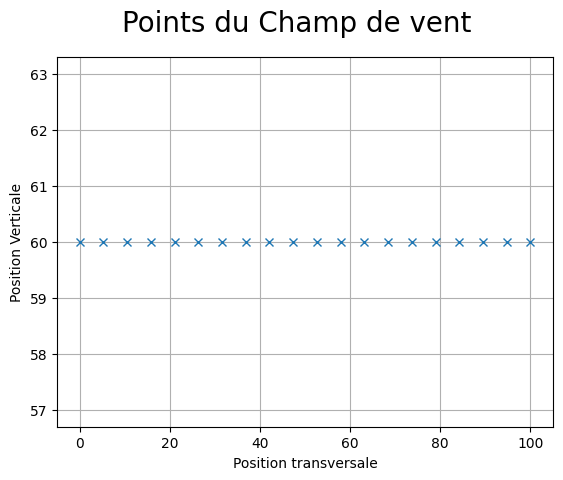

In [4]:
grid = Locations.create("grid", ny=(params.ny), nz=(params.nz), ymin=(params.ymin), ymax=(params.ymax), zmin=(params.zmin), zmax=(params.zmax))
display_points(grid)

### Generating the wind field 

In [5]:
wind_field = WindField(params)
wind_field.compute()

_______________Wind Field Display___________________________________
Simulation Parameters:
Samples Numbers: 3000
SampleTime: 0.25
WindField Points:
Point 0 : Y=0, Z=60
Wind Values have been initialized


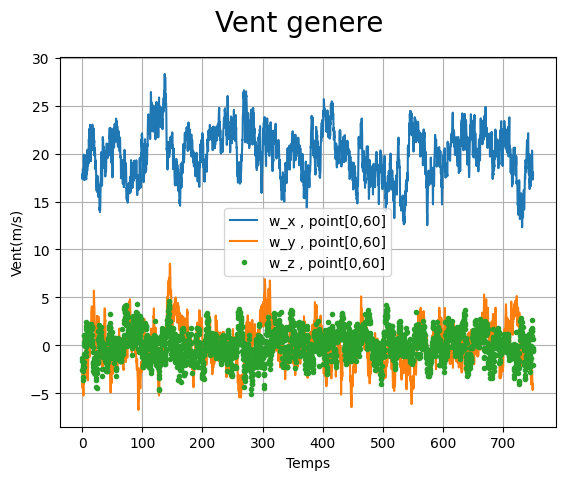

________________End OF DISPLAY____________________________________


In [6]:
from yawisi.display import  display_field
pts = [
            (0, 60)
        ]
wind_field.locations = Locations.create("points")
wind_field.locations.add_points(pts)
display_field(wind_field=wind_field)

AttributeError: 'WindField' object has no attribute 'wind'

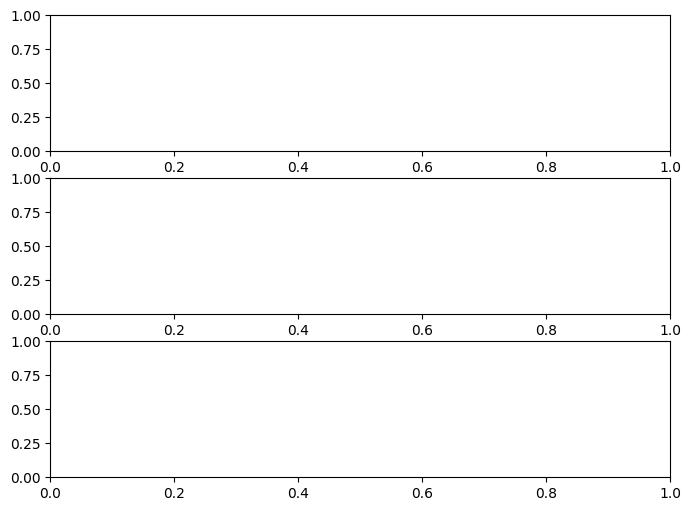

In [8]:
fig = plt.figure(figsize=(8, 6))

# Create subplots for each wind component
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Loop over wind field locations and plot wind components in each subplot
for i, (pt, wind) in enumerate(zip(wind_field.locations.points, wind_field.wind)):
    Time = [float(ii) * wind_field.params.sample_time for ii in range(wind_field.params.n_samples)]

    # Plot w_x in the first subplot (ax1)
    ax1.plot(Time, wind.wind_values[:, 0], label="u, point[%s,%s]" % (pt[0], pt[1]))

    # Plot w_y in the second subplot (ax2)
    ax2.plot(Time, wind.wind_values[:, 1], label="v, point[%s,%s]" % (pt[0], pt[1]))

    # Plot w_z in the third subplot (ax3)
    ax3.plot(Time, wind.wind_values[:, 2], label="w, point[%s,%s]" % (pt[0], pt[1]))

# Set labels and title for each subplot
ax1.set_ylabel("longitudnal(m/s)")
ax1.set_xlabel("Temps(s)")
ax1.legend()
ax1.grid()

ax2.set_ylabel("transversal(m/s)")
ax2.set_xlabel("Temps(s)")
ax2.grid()

ax3.set_ylabel("vertical(m/s)")
ax3.set_xlabel("Temps(s)")
ax3.grid()

plt.tight_layout()
plt.show()

### Standard deviation

In [7]:
wind_field.locations = Locations.create("grid", ny=(params.ny), nz=(params.nz), ymin=(params.ymin), ymax=(params.ymax), zmin=(params.zmin), zmax=(params.zmax))
ts = wind_field.get_uvwt()

In [8]:

std_u = np.std(ts[0, :, :, 0], axis=0 )
std_v = np.std(ts[1, :, :, 0], axis=0 )
std_w = np.std(ts[2, :, :, 0], axis=0 )

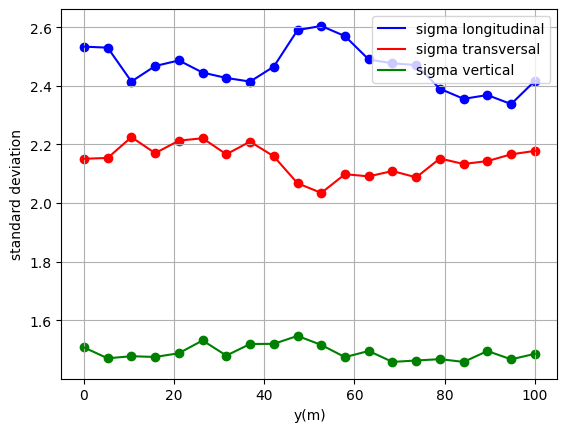

In [9]:
y = np.linspace (0, 100, 20)
plt.figure()
plt.plot(y, std_u, color='b', label='sigma longitudinal')
plt.scatter(y, std_u, color='b')
plt.plot(y, std_v, color='r', label='sigma transversal')
plt.scatter(y, std_v, color='r')
plt.plot(y, std_w, color='g', label='sigma vertical')
plt.scatter(y, std_w, color='g')
plt.grid(True)
plt.xlabel("y(m)")
plt.ylabel("standard deviation")
plt.legend(loc="upper right")
plt.show()

### Turbulence intensity

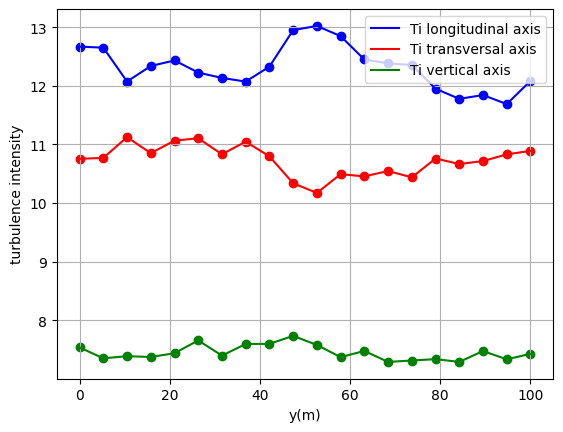

In [10]:
U_target = 20
Iu = std_u / U_target * 100
Iv =  std_v / U_target * 100
Iw = std_w / U_target * 100 
plt.figure()
plt.plot(y, Iu, color='b', label='Ti longitudinal axis')
plt.scatter(y, Iu, color='b')
plt.plot(y, Iv, color='r', label='Ti transversal axis')
plt.scatter(y, Iv, color='r')
plt.plot(y, Iw, color='g', label='Ti vertical axis')
plt.scatter(y, Iw, color='g')
plt.grid(True)
plt.xlabel("y(m)")
plt.ylabel("turbulence intensity")
plt.legend(loc="upper right")
plt.show()

### Comparison with Von Karman

In [12]:
Time = []
ii = 0
while ii < wind_field.params.n_samples:
    Time.append(float(ii) * wind_field.params.sample_time)
    ii += 1

In [11]:
Lu_target = 170
Lv_target = 100
Lw_target = 35
stdU_target = 2.6
stdV_target = 2.2
stdW_target = 1.56
U_target = 20
def ref_von_karman(f):
    x = (Lu_target/U_target) * f 
    y = (Lv_target/U_target) * f 
    z = (Lw_target/U_target) * f 

    denom_x = (1 + 70.0*(x**2)) ** (5/6)
    su_ref = ((4 * Lu_target * (stdU_target)**2) /U_target) / denom_x
    denom_y = (1 + 70.0*4*(y**2)) ** (11/6)
    sv_ref = (((4 * Lv_target * (stdV_target)**2) /U_target) * (1+188.4*4*(y**2))) / denom_y
    denom_z = (1 + 70.0*4*(z**2)) ** (11/6)
    sw_ref = (((4 * Lw_target * (stdW_target)**2) /U_target) * (1+188.4*4*(z**2)))/ denom_z
    return su_ref, sv_ref, sw_ref

f = np.linspace(0.003, 1, 1000)
su_ref, sv_ref, sw_ref = ref_von_karman(f)

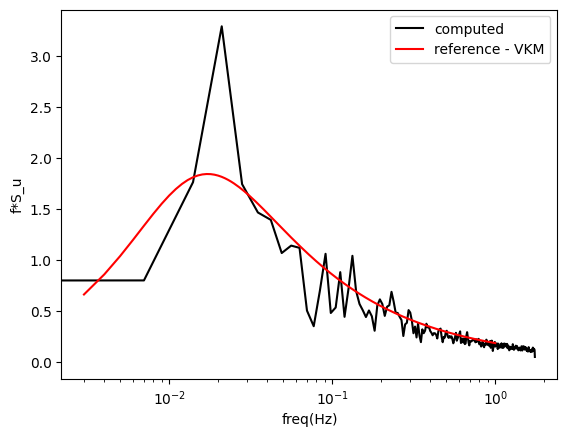

In [25]:
from scipy.signal import welch
Nblock = 6
dt = np.median(np.diff(Time))
# fs = 1/dt
fs = 0.2 
tmax = Time[-1]

nperseg = 1
ts = wind_field.get_uvwt()
u = ts[0]
v = ts[1]
w = ts[2]
Nsamples, N = u.shape[1], len(Time)
Ncoh = round(N/Nblock)
F, SU = welch(u[:, 9, 0], fs=3.5, nperseg=Ncoh, noverlap=Ncoh//2)
# SU.mean()
# SU = np.mean(SU, axis=1)
# # f, SU = welch(u, fs=fs, nperseg=nperseg, noverlap=nperseg // 2) 
plt.figure()
plt.plot(F, (F*SU.T), color='k', label="computed")
plt.plot(f, (f*su_ref.T), color='r', label="reference - VKM")
# plt.plot(f,su, color='r')
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_u")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

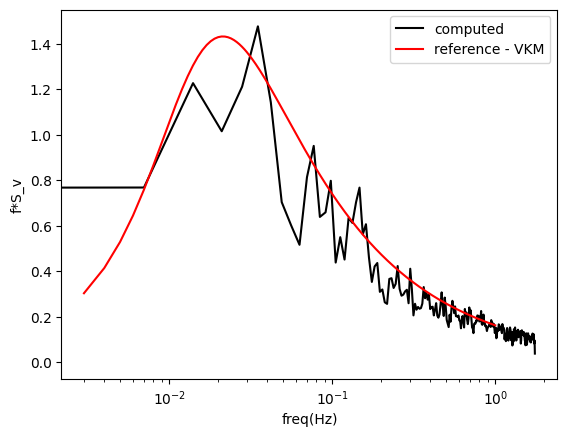

In [26]:
from scipy.signal import welch
fs = 0.1
nperseg = 1
ts = wind_field.get_uvwt()
u = ts[0]
v = ts[1]
w = ts[2]
F, SV = welch(v[:, 9, 0], fs=3.5, nperseg=Ncoh, noverlap=Ncoh//2)
plt.figure()
plt.plot(F, (F*SV.T), color='k', label="computed")
plt.plot(f, (f*sv_ref.T), color='r', label="reference - VKM")
# plt.plot(f,su, color='r')
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_v")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

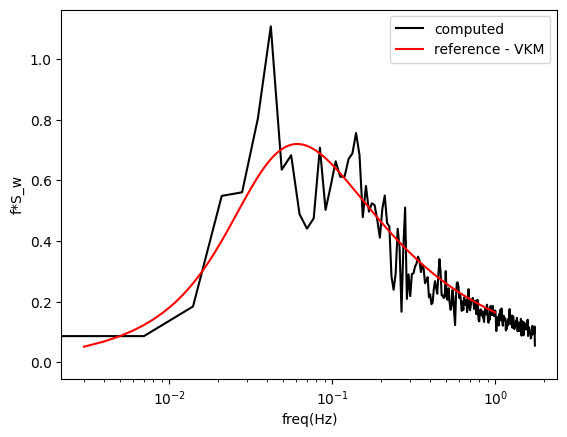

In [27]:
F, SW = welch(w[:, 9, 0], fs=3.5, nperseg=Ncoh, noverlap=Ncoh//2)
plt.figure()
plt.plot(F, (F*SW.T), color='k', label="computed")
plt.plot(f, (f*sw_ref.T), color='r', label="reference - VKM")
# plt.plot(f,su, color='r')
plt.xlabel("freq(Hz)")
plt.ylabel("f*S_w")
plt.xscale("log")
plt.legend(loc="upper right")
plt.show()

### Spatial coherence verification 

In [45]:
from scipy.signal import detrend, csd

def coherence(X, Y, Fs=2, WINDOW='hann', NPERSEG=None, NOVERLAP=None, NFFT=None):
    # Get only the fluctuating part
    X = detrend(X, type='constant')
    Y = detrend(Y, type='constant')  # remove mean

    #Get cross spectrum 
    freq, pxy = csd(X, Y, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2, nfft=NFFT)

    # Get single point spectrum
    _, pxx = csd(X, X, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2,  nfft=NFFT)
    _, pyy = csd(Y, Y, fs=Fs, window=WINDOW, nperseg=NPERSEG, noverlap=NPERSEG//2,  nfft=NFFT)

    # Normalize the cross spectrum
    cocoh = np.real(pxy / np.sqrt(pxx * pyy))  # co-coherence
    Quad = np.imag(pxy / np.sqrt(pxx * pyy))  # quad-coherence

    return cocoh, Quad, freq

In [58]:
ts = wind_field.get_uvwt()
u = ts[0] 

## parameters for numerical estimation of the co-coherence. 
Nblock = 6
Nsamples, N = u.shape[1], len(Time)
Ncoh = int(round(N/Nblock))
overlap = Ncoh//2
dt = np.median(np.diff(Time))
fs = 1/dt
# fs = 2.5

## Initializing co-coherence array
cocoh = np.zeros((Nsamples, Nsamples, Ncoh // 2))

## computation of coherence using the function coherence 
for ii in range(Nsamples):
    for jj in range(Nsamples):
        coh, _, freq = coherence(u[:, ii, 0], u[:, jj, 0], Fs=fs, NPERSEG=Ncoh, NOVERLAP=overlap, NFFT=Ncoh)
        # print(coh.shape)
        cocoh[ii, jj, :] = coh[:Ncoh//2]

In [73]:
ts = wind_field.get_uvwt()
u = ts[0] 

## parameters for numerical estimation of the co-coherence. 
Nblock = 6
Nsamples, N = u.shape[1], len(Time)
Ncoh = int(round(N/Nblock))
overlap = Ncoh//2
dt = np.median(np.diff(Time))
fs = 1/dt
# fs = 2.5

## Initializing co-coherence array
cocoh = np.zeros((Nsamples, Nsamples, Ncoh // 2))

## computation of coherence using the function coherence 
for ii in range(Nsamples):
    for jj in range(Nsamples):
        coh, _, freq = coherence(u[:, ii, 0], u[:, jj, 0], Fs=fs, NPERSEG=Ncoh, NOVERLAP=overlap, NFFT=Ncoh)
        # print(coh.shape)
        cocoh[ii, jj, :] = coh[:Ncoh//2]


## computing distance matrix (and putting unique distance values in list uniqueDist)
# from yawisi.locations import Locations
y = grid.get_distance_matrix()
uniqueDist = np.unique(np.round(y.flatten() * 100) / 100)
distTarget = [10,20,40,60]
# freq = np.linspace(0.003, 1, 1000)

## Averaging coherence 
cocoh = np.reshape(cocoh, (Nsamples*Nsamples, -1))
meanCoCoh = np.zeros((len(np.unique(uniqueDist)), cocoh.shape[1]))

for ii, dist in enumerate(np.unique(uniqueDist)):
    ind = np.where(np.round(y.flatten() * 100) / 100 == dist)[0]
    print(ii, dist, cocoh[ind, :].shape)
    meanCoCoh[ii, :] = np.nanmean(cocoh[ind, :], axis=0)
print(meanCoCoh.shape)

0 0.0 (20, 250)
(20, 250)
1 5.26 (38, 250)
(20, 250)
2 10.53 (36, 250)
(20, 250)
3 15.79 (34, 250)
(20, 250)
4 21.05 (32, 250)
(20, 250)
5 26.32 (30, 250)
(20, 250)
6 31.58 (28, 250)
(20, 250)
7 36.84 (26, 250)
(20, 250)
8 42.11 (24, 250)
(20, 250)
9 47.37 (22, 250)
(20, 250)
10 52.63 (20, 250)
(20, 250)
11 57.89 (18, 250)
(20, 250)
12 63.16 (16, 250)
(20, 250)
13 68.42 (14, 250)
(20, 250)
14 73.68 (12, 250)
(20, 250)
15 78.95 (10, 250)
(20, 250)
16 84.21 (8, 250)
(20, 250)
17 89.47 (6, 250)
(20, 250)
18 94.74 (4, 250)
(20, 250)
19 100.0 (2, 250)
(20, 250)


In [64]:
meanCoCoh.shape

(20, 250)

In [55]:
from yawisi.profile import Profile
profile = Profile(params)
umean = profile(grid)
mean_u_jk = 0.5 * np.add.outer(umean.ravel(), umean.ravel())


(250,)
(250,)


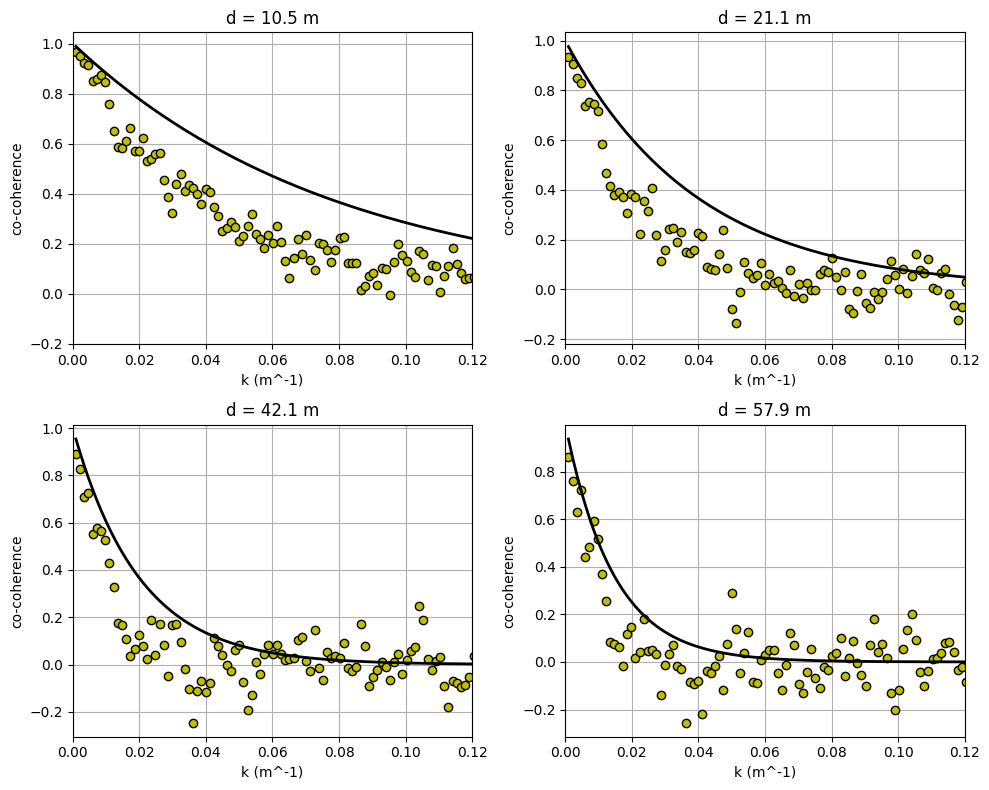

In [76]:
k = 2 * np.pi * freq / 20

print(freq.shape)
print(meanCoCoh[0, :].reshape((meanCoCoh.shape[1],)).shape)


fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for ii, target in enumerate(distTarget, 1):
    indDist = []
    ind = np.argmin(np.abs(uniqueDist - target))
    indDist.append(ind)
    ax = axs[(ii - 1) // 2, (ii - 1) % 2]
    ax.plot(k, meanCoCoh[indDist, :].reshape((meanCoCoh.shape[1],)), 'ko', markerfacecolor='y')
    ax.plot(k, np.exp(-7.5 * y[0, ind] * freq / 20), 'k', linewidth=2)
    ax.set_title('d = {:.1f} m'.format(uniqueDist[ind]))
    ax.set_xlim([0, 0.12])
    ax.set_xlabel('k (m^-1)')
    ax.set_ylabel('co-coherence')
    ax.grid(True)

plt.tight_layout()
plt.show()